In [187]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import plot_confusion_matrix

In [188]:
data0 = pd.read_csv(r'C:\Users\Public\Documents\Phishing-Website-Detection\DataFiles\5.urldata.csv')
data0.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0
2,hubpages.com,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0
4,icicibank.com,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0


In [189]:
data0.columns
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Domain         10000 non-null  object
 1   Have_IP        10000 non-null  int64 
 2   Have_At        10000 non-null  int64 
 3   URL_Length     10000 non-null  int64 
 4   URL_Depth      10000 non-null  int64 
 5   Redirection    10000 non-null  int64 
 6   https_Domain   10000 non-null  int64 
 7   TinyURL        10000 non-null  int64 
 8   Prefix/Suffix  10000 non-null  int64 
 9   DNS_Record     10000 non-null  int64 
 10  Web_Traffic    10000 non-null  int64 
 11  Domain_Age     10000 non-null  int64 
 12  Domain_End     10000 non-null  int64 
 13  iFrame         10000 non-null  int64 
 14  Mouse_Over     10000 non-null  int64 
 15  Right_Click    10000 non-null  int64 
 16  Web_Forwards   10000 non-null  int64 
 17  Label          10000 non-null  int64 
dtypes: int64(17), object(1)
mem

In [190]:
data0.describe()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000
mean,0.005500,0.022600,0.773400,3.072000,0.013500,0.000200,0.090300,0.093200,0.100800,0.845700,0.413700,0.8099,0.090900,0.06660,0.99930,0.105300,0.500000
std,0.073961,0.148632,0.418653,2.128631,0.115408,0.014141,0.286625,0.290727,0.301079,0.361254,0.492521,0.3924,0.287481,0.24934,0.02645,0.306955,0.500025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000,0.000000,0.00000,1.00000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000,0.000000,0.00000,1.00000,0.000000,0.500000
75%,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0000,0.000000,0.00000,1.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.00000,1.00000,1.000000,1.000000


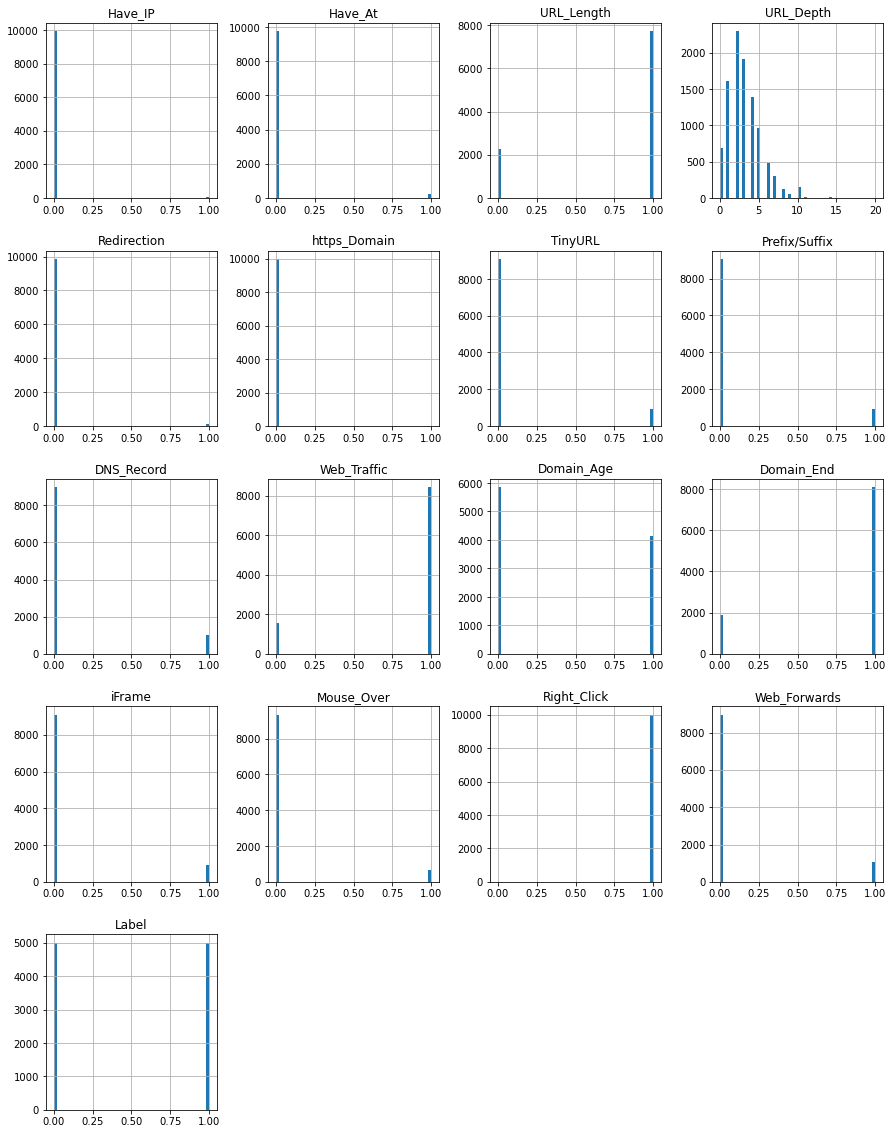

In [191]:
# Plotting the data distribution
data0.hist(bins=50, figsize=(15, 20))
plt.show()

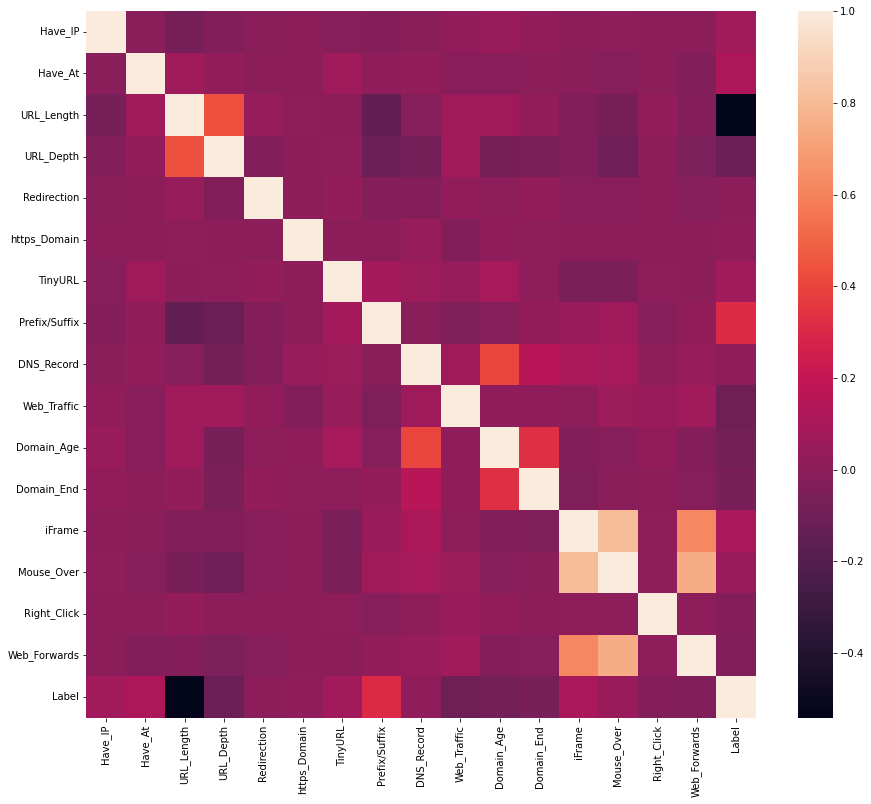

In [192]:
#plotting the correlation matrix
plt.figure(figsize = (15,13))
sns.heatmap(data0.corr())
plt.show()

In [171]:
data = data0.drop(['Domain'], axis=1).copy()
# checking the data for null or missing values
data.isnull().sum()
data = data.sample(frac=1).reset_index(drop=True)
data.head()
# Sepratating & assigning features and target columns to X & y
y = data['Label']
X = data.drop('Label', axis=1)
X.shape, y.shape

((10000, 16), (10000,))

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train.shape, X_test.shape

((8000, 16), (2000, 16))

In [173]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info) # measures the dependency between the variables
mutual_info.index = X_train.columns
mutual_info = mutual_info.sort_values(ascending=False)
print(mutual_info)

URL_Length       0.186478
URL_Depth        0.071034
Prefix/Suffix    0.061066
Web_Traffic      0.011762
Have_At          0.007762
DNS_Record       0.006872
Domain_End       0.006310
https_Domain     0.000563
iFrame           0.000119
Have_IP          0.000000
Redirection      0.000000
TinyURL          0.000000
Domain_Age       0.000000
Mouse_Over       0.000000
Right_Click      0.000000
Web_Forwards     0.000000
dtype: float64


<AxesSubplot:>

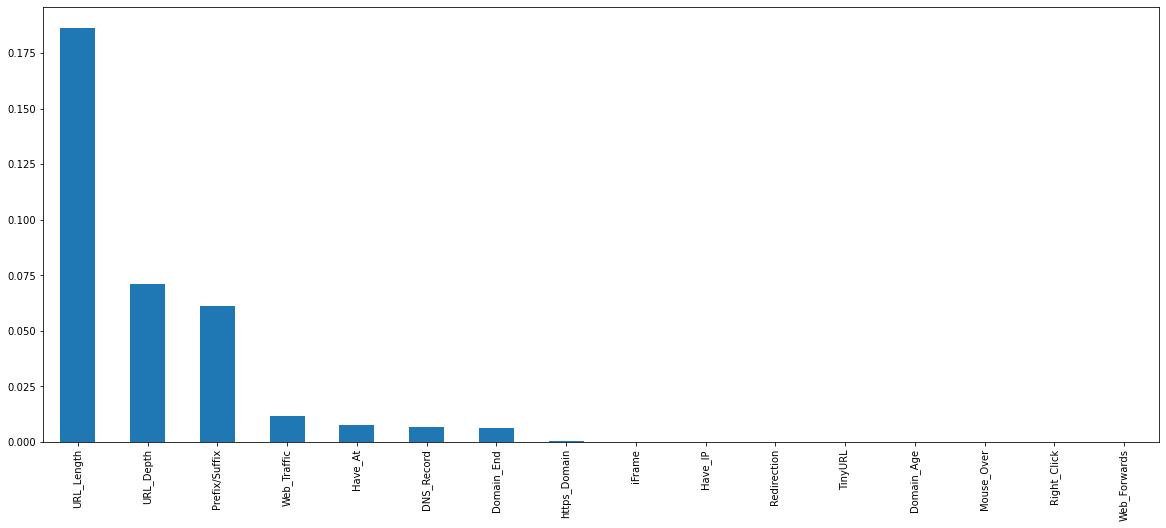

In [174]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [175]:
ML_Model = []
acc_train = []
acc_test = []
def storeResults(model, a, b):
    ML_Model.append(model)
    acc_train.append(round(a, 3))
    acc_test.append(round(b, 3))

# MODELS

## SVM MODEL


In [176]:
# Support vector machine model
# instantiate the model
svm = SVC(kernel='rbf', degree=6, C=1.0, random_state=12)
# fit the model
svm.fit(X_train, y_train)

y_test_svm = svm.predict(X_test)
y_train_svm = svm.predict(X_train)

# computing the accuracy of the model performance
acc_train_svm = accuracy_score(y_train, y_train_svm)
acc_test_svm = accuracy_score(y_test, y_test_svm)

print("SVM: Accuracy on training Data: {:.3f}".format(acc_train_svm))
print("SVM : Accuracy on test Data: {:.3f}".format(acc_test_svm))
storeResults('SVM', acc_train_svm, acc_test_svm)

SVM: Accuracy on training Data: 0.823
SVM : Accuracy on test Data: 0.808


### Confusoin Matrix

C:\Users\Mohit yadav\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mohit yadav\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


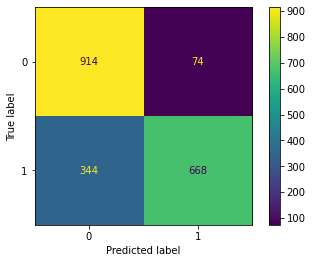

In [177]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression() # fit model
clf.fit(X_train,y_train)
disp = plot_confusion_matrix(clf,X_test,y_test)

## RANDOM FOREST MODEL

In [178]:
# Random Forest model
# instantiate the model
forest = RandomForestClassifier(max_depth=5)

# fit the model
forest.fit(X_train, y_train)
y_test_forest = forest.predict(X_test)
y_train_forest = forest.predict(X_train)

# computing the accuracy of the model performance
acc_train_forest = accuracy_score(y_train, y_train_forest)
acc_test_forest = accuracy_score(y_test, y_test_forest)

print("Random forest: Accuracy on training Data: {:.3f}".format(
    acc_train_forest))
print("Random forest: Accuracy on test Data: {:.3f}".format(acc_test_forest))
storeResults('Random Forest', acc_train_forest, acc_test_forest)

Random forest: Accuracy on training Data: 0.817
Random forest: Accuracy on test Data: 0.814


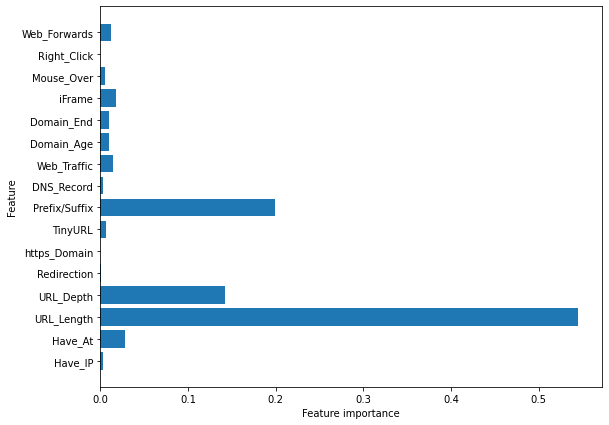

In [179]:
plt.figure(figsize=(9, 7))
n_features = X_train.shape[1]
plt.barh(range(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

## XGBoost CLASSIFICATION MODEL


In [180]:

# XGBoost Classification model
# instantiate the model
xgb = XGBClassifier(learning_rate=0.4, max_depth=7)
# fit the model
xgb.fit(X_train, y_train)

# predicting the target value from the model for the samples
y_test_xgb = xgb.predict(X_test)
y_train_xgb = xgb.predict(X_train)

# computing the accuracy of the model performance
acc_train_xgb = accuracy_score(y_train, y_train_xgb)
acc_test_xgb = accuracy_score(y_test, y_test_xgb)

print("XGBoost: Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost : Accuracy on test Data: {:.3f}".format(acc_test_xgb))

# storing the results. The below mentioned order of parameter passing is important.
# Caution: Execute only once to avoid duplications.
storeResults('XGBoost', acc_train_xgb, acc_test_xgb)

XGBoost: Accuracy on training Data: 0.868
XGBoost : Accuracy on test Data: 0.855


In [181]:
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model

In [182]:
input_dim = X_train.shape[1]
encoding_dim = input_dim

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",
                activity_regularizer=regularizers.l1(10e-4))(input_layer)
encoder = Dense(int(encoding_dim), activation="relu")(encoder)

encoder = Dense(int(encoding_dim-2), activation="relu")(encoder)
code = Dense(int(encoding_dim-4), activation='relu')(encoder)
decoder = Dense(int(encoding_dim-2), activation='relu')(code)

decoder = Dense(int(encoding_dim), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_56 (Dense)            (None, 16)                272       
                                                                 
 dense_57 (Dense)            (None, 16)                272       
                                                                 
 dense_58 (Dense)            (None, 14)                238       
                                                                 
 dense_61 (Dense)            (None, 16)                240       
                                                                 
 dense_62 (Dense)            (None, 16)                272       
                                                                 
Total params: 1,294
Trainable params: 1,294
Non-trainable p

In [183]:
#compiling the model
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

#Training the model
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=True, validation_split=0.2) 

Epoch 1/10
100/100 [==============================] - 2s 6ms/step - loss: 0.3892 - accuracy: 0.3162 - val_loss: -0.4452 - val_accuracy: 0.8369
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: -0.4932 - accuracy: 0.7322 - val_loss: -0.5731 - val_accuracy: 0.3656
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: -0.5417 - accuracy: 0.1538 - val_loss: -0.5929 - val_accuracy: 0.0037
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: -0.5586 - accuracy: 0.0016 - val_loss: -0.6099 - val_accuracy: 0.0019
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: -0.5720 - accuracy: 0.0016 - val_loss: -0.6181 - val_accuracy: 0.0019
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: -0.5842 - accuracy: 0.0016 - val_loss: -0.6364 - val_accuracy: 0.0019
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: -0.5997 - accuracy: 0.0016 - val_loss: -0.6504 - val_accuracy: 

In [184]:
acc_train_auto = autoencoder.evaluate(X_train, X_train)[1]
acc_test_auto = autoencoder.evaluate(X_test, X_test)[1]

print('\nAutoencoder: Accuracy on training Data: {:.3f}' .format(acc_train_auto))
print('Autoencoder: Accuracy on test Data: {:.3f}' .format(acc_test_auto))

63/63 [==============================] - 0s 2ms/step - loss: -0.6096 - accuracy: 0.0965

Autoencoder: Accuracy on training Data: 0.106
Autoencoder: Accuracy on test Data: 0.097


In [185]:
#storing the results. The below mentioned order of parameter passing is important.
#Caution: Execute only once to avoid duplications.
storeResults('AutoEncoder', acc_train_auto, acc_test_auto)
#creating dataframe
results = pd.DataFrame({ 'ML Model': ML_Model,    
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test})
#Sorting the datafram on accuracy
results.sort_values(by=['Test Accuracy', 'Train Accuracy'], ascending=False)

,ML Model,Train Accuracy,Test Accuracy
2,XGBoost,0.868,0.854
1,Random Forest,0.817,0.814
0,SVM,0.823,0.808
3,AutoEncoder,0.106,0.097
